# Modeling Photo-z Distribution (DNF)

In this notebook, we model the photo-z properties (bias,scatter) as a function of the redshift. Then, we apply the following task into the data:
* photo_z_error = scatter(mag_i)
* redshift window study

In [1]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")
from main import copacabana
from make_input_files.make_input_datasets import *

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [4]:
root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
cfg  = root+'config_buzzard_v2.yaml'
copa = copacabana(cfg,dataset='buzzard_v2')

d1, d2 = [], []
for mfile in copa.master_fname_tile_list:
    g, c = load_copa_input_catalog(mfile,copa.kwargs,pz_file=None,simulation=True)
    d1.append(g)
    d2.append(c)

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00035.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00038.hdf5
/data/des61.a/data/johnny

In [5]:
gal = vstack(d1)

In [6]:
cat = vstack(d2)

In [7]:
mask = gal['Bkg']
np.count_nonzero(mask)

5924668

In [8]:
g = gal

### Define Variables

In [154]:
idx = np.where(gal['mag'][:,2]<=27)[0]

In [155]:
mask = g['True']

In [156]:
zt   = g['z_true'][idx]
zp   = g['z'][idx]
zerr = g['zerr'][idx]

zcls = g['redshift'][idx]
zoff = g['zoffset'][idx]#-0.09*(1+zcls)
magi = g['mag'][:,2]

In [157]:
deltaz = (zp-zt)/(1+zt)
deltaz_abs = np.abs(deltaz)

In [158]:
non_fitted = (zt>0.)&(zp==0)
print('# of non fitted galaxies')
print(np.count_nonzero(non_fitted))
print('%.2f perc'%(np.round(100.*np.count_nonzero(non_fitted)/len(zt),2)))

# of non fitted galaxies
328475
3.01 perc


In [159]:
bias = np.median(zoff)
print('bias: %.3f'%(bias))

bias: 0.012


# Set Redshift Limits

The DNF photo-z sample is limited on the i-band up to $mag_i=23$. The magnitude cut imposes a natural cut on the redshift range of our selection.

In [160]:
z_max = np.min(zt[mask&non_fitted])

In [161]:
print('The redshift max is %.3f'%(z_max))

The redshift max is 0.623


In [162]:
zvec = np.linspace(0.01,3,40)
xmin,xmax=-0.1,1.1
def identity(ztru,z,xmin=-0.05,xmax=2.,ax=None,alpha=0.01):
    if ax is None: ax=plt.axes()
    ax.plot(zvec,zvec,ls='--',color='k')
    ax.scatter(ztru,z,alpha=alpha,s=10,label='true members')
    ax.axhline(1.,color='k')
    ax.axvline(1.,color='k')
    ax.set_xlabel(r'$z_{true}$',fontsize=18)
    ax.set_ylabel(r'$z_{ph}$',fontsize=18)
    ax.set_ylim(xmin,xmax)
    ax.set_xlim(xmin,xmax)

Text(0.5,1,'Only True Members')

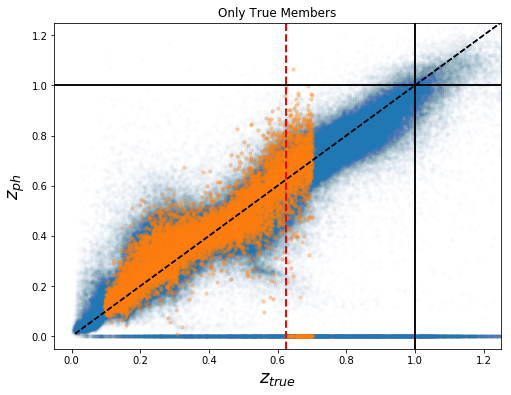

In [163]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
identity(zt[::20],zp[::20],xmax=1.25,ax=ax)
identity(zt[mask][::10],zp[mask][::10],xmax=1.25,alpha=0.3,ax=ax)
ax.axvline(z_max,color='r',ls='--',lw=2)
plt.title('Only True Members')

# Photo-z Statistics 

Here we provide a summary of the photo-z accuracy in this sample.

In [325]:
def group_by(x,keys):
    return [x[idx] for idx in keys]
    
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    indices = []
    means = (xedges[1:]+xedges[:-1])/2.
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [326]:
def fractional_error_percentile(var):
    p16 = np.nanpercentile(var, 16)
    p84 = np.nanpercentile(var, 84)
    score = 0.5*(p84-p16)
    return score

def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(var):
    sigmaNMAD = 1.48*mad(var)
    return sigmaNMAD

def get_outlier_frac(var):
    sigmaNMAD = 1.48*mad(var)
    bias      = np.nanmedian(var)
    out       = np.where(np.abs((var-bias)>=2.*sigmaNMAD))[0]
    frac      = 1.*out.size/var.size
    return frac

In [327]:
def filter_nan_inf(x):
    mask = np.isinf(x)|np.isnan(x)
    x[mask] = -99.
    return x

In [328]:
dx = 0.025
zbins = np.arange(0.1-dx/2,.7+dx,dx)
keys,zb  = get_bins(zt,zbins)
dz_bins_g= group_by(deltaz,keys)
zerr_bins= group_by(zerr,keys)

scatter_b= np.array([get_sigmaNMAD(db)    for db in dz_bins_g])
bias_b   = np.array([np.median(db)        for db in dz_bins_g])
of_b     = np.array([get_outlier_frac(db) for db in dz_bins_g]) 
zerr_b   = np.array([np.nanmedian(db)     for db in  zerr_bins])

In [329]:
keys,zb  = get_bins(zt[mask],zbins)
dz_bins_g= group_by(deltaz[mask],keys)


scatter_bt= np.array([get_sigmaNMAD(db)    for db in dz_bins_g])
bias_bt   = np.array([np.median(db)        for db in dz_bins_g])
of_bt     = np.array([get_outlier_frac(db) for db in dz_bins_g]) 

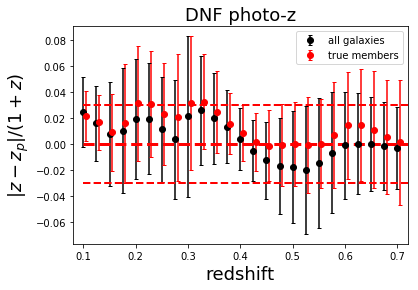

In [330]:
plt.errorbar(zb,bias_b,color='k',fmt='o',capsize=2,yerr=scatter_b,label='all galaxies')
plt.errorbar(zb+0.005,bias_bt,color='r',fmt='o',capsize=2,yerr=scatter_bt,label='true members')

plt.plot([0.1,1.],[0.,0.],'r--',lw=3)
plt.plot([0.1,1.],[-.03,-0.03],'r--',lw=2)
plt.plot([0.1,1.],[+.03,+0.03],'r--',lw=2)

plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.title('DNF photo-z',fontsize=18)
plt.xlim(0.08,0.72)
plt.legend()

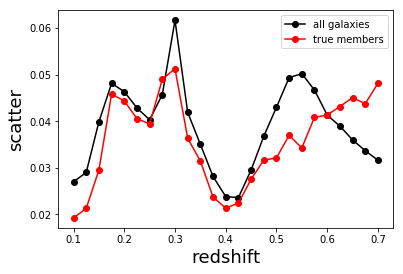

In [331]:
plt.plot(zb,scatter_b,'o-',color='k',label='all galaxies')
plt.plot(zb,scatter_bt,'o-',color='r',label='true members')
plt.ylabel('scatter',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.legend()

Text(0.5,0,'redshift')

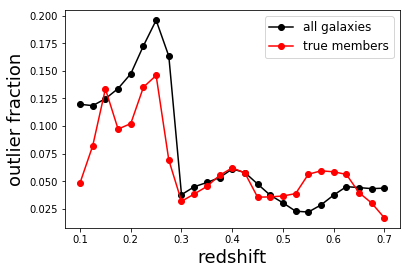

In [332]:
plt.plot(zb,of_b,'o-',color='k',label='all galaxies')
plt.plot(zb,of_bt,'o-',color='r',label='true members')
plt.ylabel('outlier fraction',fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('redshift',fontsize=18)

Text(0.5,0,'redshift')

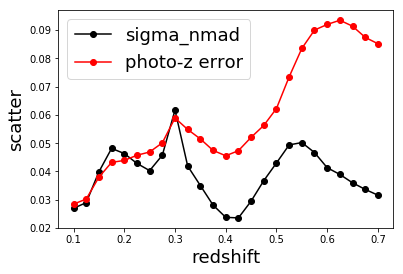

In [333]:
plt.plot(zb,scatter_b,'o-',color='k',label='sigma_nmad')
plt.plot(zb,zerr_b,'o-',color='r',label='photo-z error')
plt.ylabel('scatter',fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('redshift',fontsize=18)

Text(0,0.5,'photoz_error/scatter')

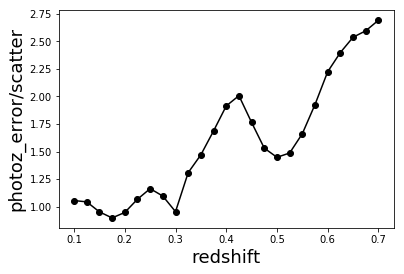

In [334]:
plt.plot(zb,zerr_b/scatter_b,'o-',color='k',label='sigma_nmad')
plt.xlabel('redshift',fontsize=18)
plt.ylabel('photoz_error/scatter',fontsize=18)

The photoz_error overstimates the mean error after redshift 0.3.

In [335]:
import scipy
redshift_window2 = scipy.interpolate.interp1d(zb,scatter_bt)

## As a function of magnitude


In [314]:
zcut, = np.where(zcls<=z_max)
mag_min = np.percentile(magi[zcls<=0.11],1)
mag_max = np.percentile(magi[np.abs(zcls-z_max)<=0.01],99)
print('magnitude limits')
print('min, max: %.2f, %.2f'%(mag_min,mag_max))

magnitude limits
min, max: 15.02, 23.00


In [315]:
mag_min, mag_max = 14.5, 23

Text(0,0.5,'mag_i')

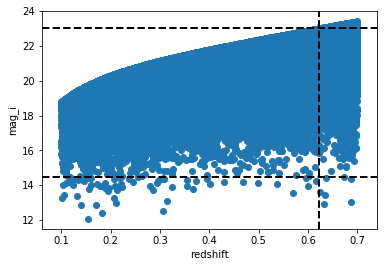

In [316]:
plt.scatter(zcls[::50],magi[::50])
plt.axvline(z_max  , color='k', ls='--',lw=2)
plt.axhline(mag_min, color='k', ls='--',lw=2)
plt.axhline(mag_max, color='k', ls='--',lw=2)
plt.xlabel('redshift')
plt.ylabel('mag_i')

In [317]:
mbins      = np.arange(mag_min-0.25/2, mag_max, 0.25)
m_keys,mb  = get_bins(magi,mbins)
m_dz_bins_g= group_by(deltaz,m_keys)
m_zerr_bins= group_by(zerr  ,m_keys)

m_scatter_b= np.array([get_sigmaNMAD(db)    for db in m_dz_bins_g])
m_bias_b   = np.array([np.nanmedian(db)     for db in  m_dz_bins_g])
m_zerr_b   = np.array([[np.nanmedian(db),np.nanstd(db)]     for db in  m_zerr_bins])
m_of_b     = np.array([get_outlier_frac(db) for db in m_dz_bins_g]) 

In [318]:
mb

array([14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
       16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75,
       19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75, 21.  ,
       21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75])

In [319]:
m_keys,mb   = get_bins(magi[(mask)&(zcls<=z_max)],mbins)
m_dz_bins_gt= group_by(deltaz[(mask)&(zcls<=z_max)],m_keys)

m_scatter_bt= np.array([get_sigmaNMAD(db)    for db in m_dz_bins_gt])
m_bias_bt   = np.array([np.median(db)        for db in m_dz_bins_gt])
m_of_bt     = np.array([get_outlier_frac(db) for db in m_dz_bins_gt]) 

Text(0.5,1,'all galaxies')

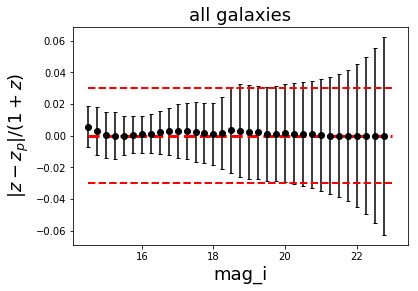

In [320]:
plt.errorbar(mb,m_bias_b,color='k',fmt='o',capsize=2,yerr=m_scatter_b)
# plt.errorbar(mb+0.1,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.title('all galaxies',fontsize=18)

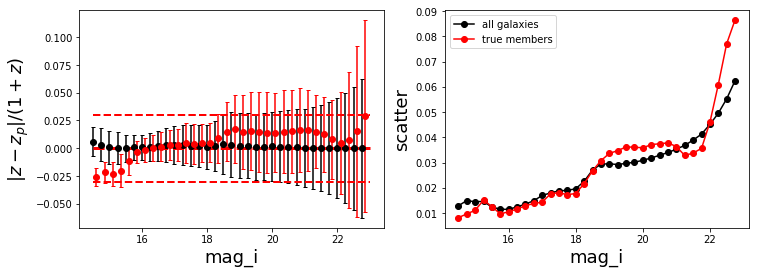

In [321]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.errorbar(mb,m_bias_b,color='k',fmt='o',capsize=2,yerr=m_scatter_b)
plt.errorbar(mb+0.1,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)

fig.add_subplot(122)
plt.plot(mb,m_scatter_b,'o-',color='k',label='all galaxies')
plt.plot(mb,m_scatter_bt,'o-',color='r',label='true members')
plt.ylabel('scatter',fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.legend()


Text(0.5,0,'mag_i')

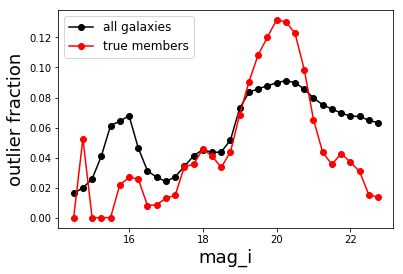

In [322]:
plt.plot(mb,m_of_b,'o-',color='k',label='all galaxies')
plt.plot(mb,m_of_bt,'o-',color='r',label='true members')
plt.ylabel('outlier fraction',fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('mag_i',fontsize=18)

Text(0.5,0,'mag_i')

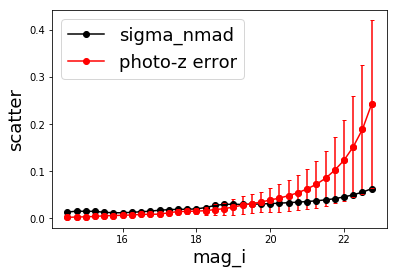

In [323]:
plt.plot(mb,m_scatter_b,'o-',color='k',label='sigma_nmad')
plt.plot(mb,m_zerr_b[:,0],'o-',color='r',label='photo-z error')

plt.errorbar(mb,m_zerr_b[:,0],color='r',fmt='o',capsize=2,yerr=m_zerr_b[:,1])

plt.ylabel('scatter',fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('mag_i',fontsize=18)

Text(0,0.5,'photoz_error/scatter')

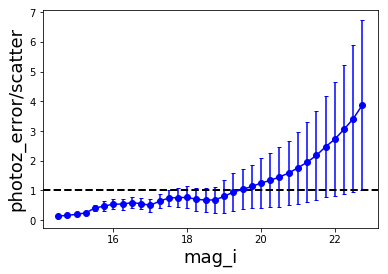

In [324]:
plt.errorbar(mb,m_zerr_b[:,0]/m_scatter_b,color='b',fmt='o-',capsize=2,yerr=m_zerr_b[:,1]/m_scatter_b)
plt.axhline(1,color='k',ls='--',lw=2)
# plt.plot(mb,m_zerr_b[:,0]/m_scatter_b,'o-',color='k',label='sigma_nmad')
plt.xlabel('mag_i',fontsize=18)
plt.ylabel('photoz_error/scatter',fontsize=18)

## Choose Photo-z Model

...

In [209]:
r_max = 1. #Mpc
rmask = (g['R']<r_max)&(np.abs(zoff)<=0.06)

m_keys,mb  = get_bins(magi[rmask],mbins)
m_dz_bins_g= group_by(deltaz[rmask],m_keys)
m_zerr_bins= group_by(zerr  ,m_keys)

m_scatter_r= np.array([np.nanstd(db)    for db in m_dz_bins_g])
m_bias_r   = np.array([np.nanmedian(db)     for db in  m_dz_bins_g])
m_zerr_r   = np.array([[np.nanmedian(db),np.nanstd(db)]     for db in  m_zerr_bins])
m_of_r     = np.array([get_outlier_frac(db) for db in m_dz_bins_g]) 

Text(0.5,1,'R < 1.0 Mpc')

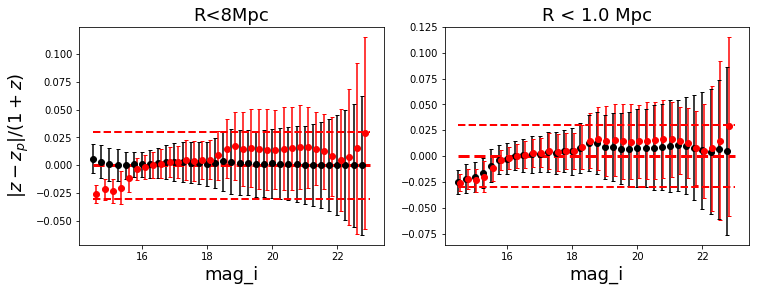

In [210]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.errorbar(mb,m_bias_b,color='k',fmt='o',capsize=2,yerr=m_scatter_b)
plt.errorbar(mb+0.1,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)
plt.title('R<8Mpc',fontsize=18)

fig.add_subplot(122)
plt.errorbar(mb,m_bias_r,color='k',fmt='o',capsize=2,yerr=m_scatter_r)
plt.errorbar(mb+0.05,m_bias_bt,color='r',fmt='o',capsize=2,yerr=m_scatter_bt)
plt.plot([mag_min,mag_max],[0.,0.],'r--',lw=3)
plt.plot([mag_min,mag_max],[-.03,-0.03],'r--',lw=2)
plt.plot([mag_min,mag_max],[+.03,+0.03],'r--',lw=2)
plt.xlabel('mag_i',fontsize=18)
plt.title('R < %.1f Mpc'%r_max,fontsize=18)

In [211]:
zerr_new = np.interp(magi, mb, m_scatter_r)

### Save Model

In [212]:
## boundaries point

def add_boundary_points(x):
    return np.hstack([x[0],x,x[-1]])

xbins  = np.hstack([12.,mb,23.])
bias   = add_boundary_points(m_bias_r)
scatter= add_boundary_points(m_scatter_r)
off    = add_boundary_points(m_of_r)

In [213]:
scatter

array([0.01194666, 0.01194666, 0.01404497, 0.01471906, 0.01474357,
       0.01565202, 0.01424231, 0.01494053, 0.01387012, 0.0159505 ,
       0.01790894, 0.01742071, 0.01920718, 0.02032145, 0.02046502,
       0.02285951, 0.02453179, 0.02695653, 0.02989847, 0.03079676,
       0.03316175, 0.03467869, 0.03628575, 0.0380185 , 0.03764156,
       0.04104353, 0.04166257, 0.04476827, 0.04373781, 0.04730419,
       0.05053046, 0.05656626, 0.06080694, 0.06716299, 0.08128555,
       0.08128555])

In [145]:
outfile=root+'aux_files/modelDNF_correction_mag_buzzard.txt'

In [150]:
## Saving the output
savefile = open(outfile, "w")
with open(outfile, "w") as savefile:
    header = '#mag  ,bias  ,sigma,outlierFrac\n'
    savefile.write(header)
    for i in range(len(xbins)):
        line = '%.3f,%.3f,%.3f,%.3f\n'%(xbins[i],bias[i],scatter[i],off[i])
        savefile.write(line)
savefile.close()

In [147]:
root

'/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'

## Assign Model

In [214]:
def assign_photoz_error(magi,model_file):
    zres    = np.genfromtxt(model_file,delimiter=',')
    xb,mean,sigma = zres[:,0],zres[:,1],zres[:,2]

    bias      = np.interp(magi,xb,mean)
    zwindow_z = np.interp(magi,xb,sigma) ##np.interp(zcls,zb,sigma)
    return zwindow_z,bias

In [215]:
## Redshift Window
dx        = 0.025
zbins     = np.arange(0.1-dx/2,.7+dx,dx)
z_keys,zb = get_bins(zcls,zbins)
zw        = np.array([np.median(zerr_new[idx][rmask[idx]]) for idx in z_keys])

Text(0.5,0,'redshift')

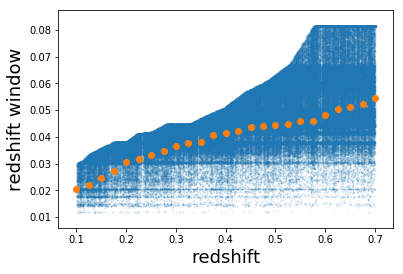

In [216]:
plt.scatter(zcls[::40],zerr_new[::40],s=1,alpha=0.1)
plt.scatter(zb,zw)
plt.ylabel('redshift window',fontsize=18)
plt.xlabel('redshift',fontsize=18)

In [217]:
xbins = zb
bias  = np.zeros_like(zb)
scatter= zw
off   = bias 

In [158]:
outfile=root+'aux_files/modelDNF_correction_z_buzzard.txt'

In [159]:
## Saving the output
savefile = open(outfile, "w")
with open(outfile, "w") as savefile:
    header = '#z  ,bias  ,sigma,outlierFrac\n'
    savefile.write(header)
    for i in range(len(xbins)):
        line = '%.3f,%.3f,%.3f,%.3f\n'%(xbins[i],bias[i],scatter[i],off[i])
        savefile.write(line)
savefile.close()

In [89]:
zerr_new,bias = assign_photoz_error(gal['mag'][:,2],outfile)
zoff = gal['zoffset']-bias

In [90]:
tm_mask   = gal['True']
zerr_true = zerr_new[tm_mask]
mi = gal['mag'][:,2]
zi = gal['redshift']

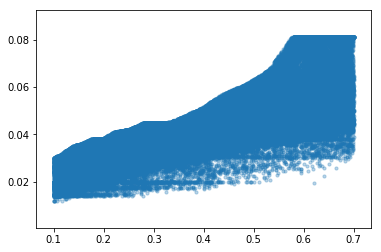

In [91]:
plt.scatter(zi[tm_mask],zerr_true,s=10,alpha=0.3)

In [133]:
ccid  = cat['CID']
czcls = cat['redshift']
cid    = gal['CID']

keys = list(chunks(cid,ccid))
keyst= list(chunks(cid[tm_mask],ccid))

In [134]:
r_max = 8.*0.7 #Mpc
rmask = (gal['R']<r_max)&(np.abs(zoff)<=0.06)

In [135]:
#keys[0][rmask[keys[0]]]#[keys[0]]

In [136]:
zwindow = np.array([np.median(zerr_new[idx][rmask[idx]]) for idx in keys])
zwindowt = np.array([np.median(zerr_true[idx]) for idx in keyst])

median :0.98 
scatter:0.053 


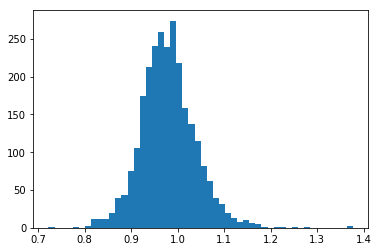

In [137]:
ratio = zwindowt/np.interp(czcls,zb,zw)
print('median :%.2f '%(np.median(ratio)))
print('scatter:%.3f '%(get_sigmaNMAD(ratio)))

_ = plt.hist(ratio,bins=50)

median :0.98 
scatter:0.051 


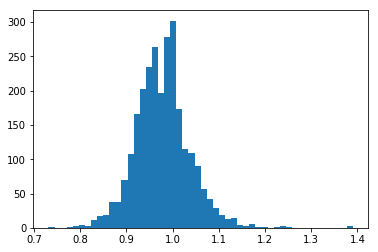

In [138]:
ratio2= zwindowt/zwindow
print('median :%.2f '%(np.median(ratio2)))
print('scatter:%.3f '%(get_sigmaNMAD(ratio2)))

_ = plt.hist(ratio2,bins=50)

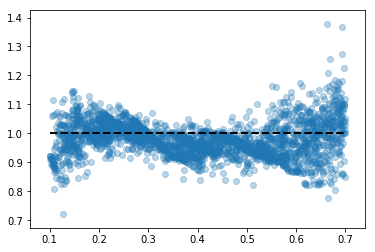

In [140]:
plt.scatter(czcls,ratio,alpha=0.3)
plt.plot([0.1,0.7],[1.0,1.0],'k--',lw=2.)

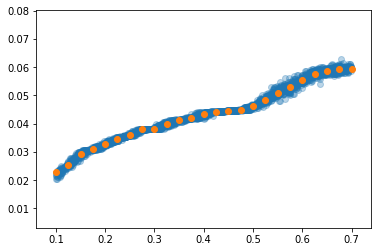

In [106]:
plt.scatter(czcls,zwindow,alpha=0.3)
plt.scatter(zb,zw)
# plt.scatter(czcls,zwindowt,s=10)

In [59]:
from make_input_files.make_photoz_pz import generate_photoz_models

generate_photoz_models('bias',copa.master_fname_tile_list,0.03,zmodel_file=outfile,zmodel_type='mag',group_name='dnf_model',nCores=60)

Generating photoz catalog: dnf_model

Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
Computing pz0
Writing outfile
partial time: 0.83 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
Computing pz0
Writing outfile
partial time: 1.15 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
Computing pz0
Writing outfile
partial time: 1.32 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
Computing pz0
Writing outfile
partial time: 1.75 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
Computing pz0
Writing outfile
partial time: 1.89 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00

### Check my redshift probabilities

In [10]:
magi = gal['mag'][:,2]
zcls = gal['redshift']
zw   = gal['zwindow']
zerr = gal['zerr']
zoff = gal['zoffset']
pz0  = gal['pz0']

tm   = gal['True']

In [11]:
idx = np.random.uniform(0,len(gal),size=50000).astype(int)

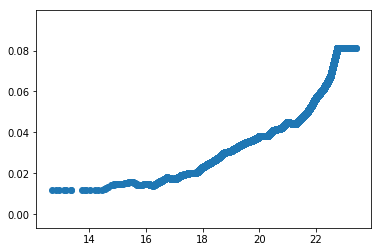

In [12]:
plt.scatter(magi[idx],zerr[idx])

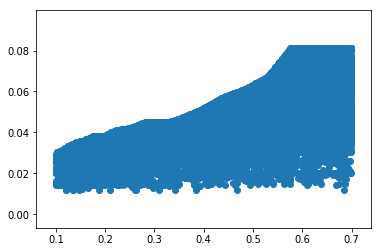

In [13]:
plt.scatter(zcls[idx],zerr[idx])

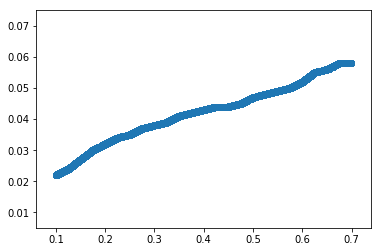

In [14]:
plt.scatter(zcls[idx],zw[idx]/(1+zcls[idx]))

(-0.1, 0.1)

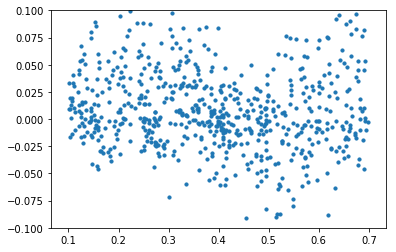

In [15]:
plt.scatter(zcls[idx][tm[idx]],zoff[idx][tm[idx]],s=10)
plt.ylim(-0.1,0.1)

(-3.0, 3.0)

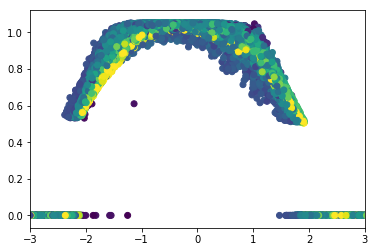

In [16]:
plt.scatter(zoff[idx]/(zw[idx]/(1+zcls[idx])),pz0[idx],c=zerr[idx])
plt.xlim(-3.,3.)

In [19]:
ccid  = cat['CID']
czcls = cat['redshift']
cid   = gal['CID']

w, = np.where(cat['redshift']<=0.6)

keys = list(chunks(cid,ccid[w]))
keyst= list(chunks(cid[tm],ccid))

In [30]:
ngals = np.array([np.nansum(pz0[idx]) for idx in keyst])
ngalst= np.array([idx.size for idx in keyst])

(6.0, 500.0)

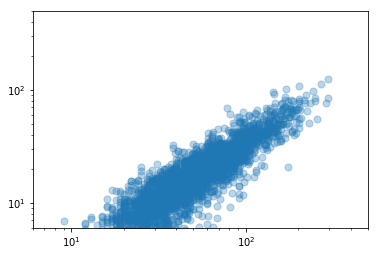

In [29]:
plt.loglog()
plt.scatter(ngalst,ngals/0.83,s=50,alpha=0.3)
plt.xlim(6.,500.)
plt.ylim(6.,500.)

In [31]:
ratio = ngals/ngalst

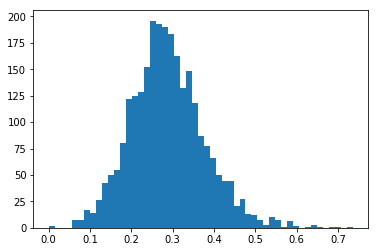

In [33]:
_ = plt.hist(ratio,bins=51)

## Debug pz(m)

In [18]:
from scipy import integrate

def compute_pdfz(zoffset,membzerr,sigma,zcls,npoints=1000,correction=False):
    ''' Computes the probability of a galaxy be in the cluster
        for an interval with width n*windows. 
        Assumes that the galaxy has a gaussian redshift PDF.

        npoints=1000 # it's accurate in 2%% level
    '''  
    zmin, zmax = zcls-5*sigma, zcls+5*sigma
    #zmin = check_boundaries(zmin,zcls)
    
    ## photo-z floor
    membzerr= np.where(membzerr<0.005,0.005,membzerr)

    ## multi dymensional arrays
    z       = np.linspace(zmin,zmax,npoints)
    #zz, yy  = np.meshgrid(z,np.array(zoffset)*(1+zcls)) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
    zz, yy  = np.meshgrid(z,np.array(zoffset)) ## dz = z-z_cls; zoffset = (z-z_cls)/(1+z_cls) 
    zz, yy2 = np.meshgrid(z,np.array(membzerr))
    
    ## assuming sigma_gal=sigma_cls:  the conv(pdf_gal,pdf_cls)-> N(mean=zp-zc,sigma=sigma0*np.sqrt(2))
    ## yy2 = np.sqrt(2)*yy2
    
    if correction:
        pdfz = gaussian_corrected(zz,yy,yy2/(1+zcls))
        pdfz_max = gaussian_corrected(z,np.zeros_like(z),sigma/(1+zcls))
            
    else:
        pdfz = gaussian(zz,yy,np.sqrt(yy2**2+sigma**2))
        pdfz_max = gaussian(z,np.zeros_like(z),sigma)
    
    w,  = np.where( np.abs(z-zcls) <= 2.*sigma) ## integrate in 1.5*sigma
    p0 = integrate.trapz(pdfz[:,w],x=zz[:,w])
    
    pmax = integrate.trapz(pdfz_max[w],x=z[w])
    pz   = p0#/pmax

    ## get out with galaxies outside 3 sigma
    pz = np.where(np.abs(zoffset-zcls) >= 2.*sigma, 0., pz)

    return pz

def check_boundaries(zmin,zcls):
    zoff_min = zcls+zmin*(1+zcls)
    if zoff_min<0:
        return zmin-zoff_min
    else:
        return zmin

def gaussian(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def gaussian_corrected(x,mu,sigma):
    sigma_cor = sigma*(1+x)
    return np.exp(-(x-mu)**2/(2*sigma_cor**2))/(sigma_cor*np.sqrt(2*np.pi))


In [19]:
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    means = (xedges[1:]+xedges[:-1])/2.
    indices = []
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [388]:
def compute_pz(znoise,zerr,zcls,zwindow=None):
    if zwindow is None: zwindow = np.median(zerr/(1+zcls))
    
    pz0 = compute_pdfz(znoise,zerr,zwindow*(1+zcls),zcls,correction=False)
    return pz0

def count_pz(znoise,zerr,zcls,zwindow=None):
    if zwindow is None: zwindow = np.median(zerr)
    zoffset = (znoise-zcls)/(1+zcls)
    pz0  = np.where(np.abs(zoffset)<=2.*zwindow,1.,0.)
    return pz0

### Analysis

In [336]:
w, = np.where(cat['redshift']<=0.6)
c  = cat[w] 

In [337]:
ccid  = c['CID']
czcls = c['redshift']
cid   = gal['CID']
tm    = gal['True']

keys = list(chunks(cid,ccid))
keyst= [idx[tm[idx]] for idx in keys]

In [338]:
ngalst= np.array([idx.size for idx in keyst])

In [339]:
def assign_photoz_error(magi,model_file):
    zres    = np.genfromtxt(model_file,delimiter=',')
    xb,mean,sigma = zres[:,0],zres[:,1],zres[:,2]

    bias      = np.interp(magi,xb,mean)
    zwindow_z = np.interp(magi,xb,sigma) ##np.interp(zcls,zb,sigma)
    return zwindow_z

def assign_photoz_bias(magi,zcls,model_file):
    zres    = np.genfromtxt(model_file,delimiter=',')
    xb,mean,sigma = zres[:,0],zres[:,1],zres[:,2]
    bias      = np.interp(magi,xb,mean)
    
    res = bias*(1+zcls)
    return res

In [340]:
mag_file = root+'aux_files/modelDNF_correction_mag_buzzard.txt'
z_file = root+'aux_files/modelDNF_correction_z_buzzard.txt'

res = np.genfromtxt(z_file,delimiter=',')
zb  = res[:,0]
sb  = res[:,2]

In [341]:
import scipy

redshift_window = scipy.interpolate.interp1d(zb,sb)

In [342]:
czcls   = c['redshift']
z       = gal['z']
zerr    = gal['zerr']

zerr_new= assign_photoz_error(gal['mag'][:,2],mag_file)*(1+gal['redshift'])
z_new   = z+assign_photoz_bias(gal['mag'][:,2],gal['redshift'],mag_file)

In [343]:
magi = gal['mag'][:,2]
zcls = gal['redshift']

In [439]:
ngals,ngalsm= [],[]

ngalsc = []
for i in range(len(czcls)):
    idx = keyst[i]
    
    zw = 0.05#redshift_window(czcls[i])
    
    pz0  = compute_pz(z[idx],zerr[idx]    ,czcls[i],zwindow=zw)
    pz0m = compute_pz(z[idx],zerr_new[idx],czcls[i],zwindow=zw)
    
    cz0  = count_pz(z[idx],zerr_new[idx],czcls[i],zwindow=zw)

    ngalsc.append(np.sum(cz0))
    ngals.append(np.sum(pz0))
    ngalsm.append(np.sum(pz0m))

In [440]:
ngals = np.array(ngals)
ngalsm= np.array(ngalsm)

ngalsc= np.array(ngalsc)

In [441]:
residualm = np.array(ngalsm)/ngalsc
residual  = np.array(ngals)/ngalsc
residualc = np.array(ngalsc)/ngalst

mean   = np.median(residualm)
sigma  = get_sigmaNMAD(residualm)

In [442]:
print('mean   : %.3f'%mean)
print('scatter: %.3f'%(sigma))

mean   : 0.825
scatter: 0.031


In [443]:
zbins = np.linspace(0.1,0.6,16)
keys,zmed = get_bins(czcls,zbins)

ymedm = np.array([np.mean(residualm[idx]) for idx in keys])
yerrm = np.array([np.std(residualm[idx]) for idx in keys])

ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr = np.array([np.std(residual[idx]) for idx in keys])

ymedc = np.array([np.mean(residualc[idx]) for idx in keys])
yerrc = np.array([np.std(residualc[idx]) for idx in keys])


Text(0.5,1,'zwindow = 0.05')

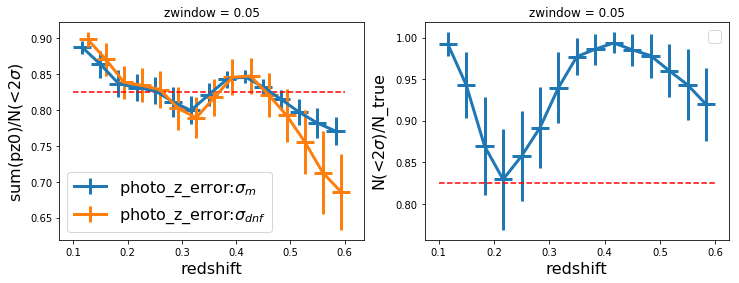

In [445]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.plot([0.1,0.6],[mean,mean],'r--')
plt.errorbar(zmed,ymedm,xerr=np.diff(zbins)/2.,yerr=yerrm   ,lw=3,label=r'photo_z_error:$\sigma_m$')
plt.errorbar(zmed+0.01,ymed,xerr=np.diff(zbins)/2.,yerr=yerr,lw=3  ,label=r'photo_z_error:$\sigma_{dnf}$')
plt.ylabel('sum(pz0)/N(<2$\sigma$)',fontsize=16)
plt.xlabel('redshift',fontsize=16)
plt.legend(fontsize=16)
plt.title('zwindow = 0.05')

fig.add_subplot(122)

plt.plot([0.1,0.6],[mean,mean],'r--')
plt.errorbar(zmed,ymedc,xerr=np.diff(zbins)/2.,yerr=yerrc   ,lw=3)
# plt.errorbar(zmed+0.01,ymed,xerr=np.diff(zbins)/2.,yerr=yerr,lw=3  ,label=r'photo_z_error:$\sigma_{dnf}$')
plt.ylabel('N(<2$\sigma$)/N_true',fontsize=16)
plt.xlabel('redshift',fontsize=16)
plt.legend(fontsize=16)
plt.title('zwindow = 0.05')

In [395]:
yerr

array([0.04431663, 0.03690546, 0.03973828, 0.03740399, 0.04221941,
       0.07456312, 0.0400922 , 0.04392965, 0.06481749, 0.05034532,
       0.07528233, 0.05399212, 0.05535803, 0.03686096, 0.06301186,
       0.08317538, 0.06076364, 0.05615305, 0.09184854, 0.06032919])

In [293]:
# prior = ngals/(1+nbkg)
# priort= ngalst/(1+nbkt)

In [34]:
nbins = np.logspace( np.log10(np.min(ngalst)), np.log10(np.max(ngalst)),11)
                    
keys,_ = get_bins(ngalst,nbins)
ymedm = np.array([np.mean(residualm[idx]) for idx in keys])
yerrm  = np.array([np.std(residualm[idx]) for idx in keys])

ymed = np.array([np.mean(residual[idx]) for idx in keys])
yerr  = np.array([np.std(residual[idx]) for idx in keys])

Text(0,0.5,'sum(pz0)/N_true')

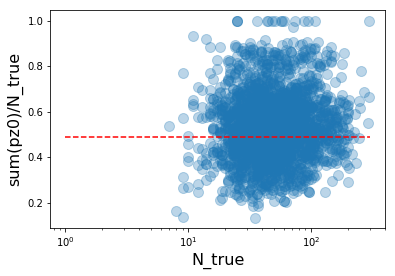

In [173]:
#plt.plot([1,300],[1,1],'k--')
plt.plot([1,300],[mean,mean],'r--')
plt.scatter(ngalst,residual,s=100,alpha=0.3)
# plt.errorbar(nmed,ymedm,xerr=np.diff(nbins)/2.,yerr=yerrm,lw=3,label='mag model')
# plt.errorbar(nmed*(1.075),ymed,xerr=np.diff(nbins)/2.,yerr=yerr,lw=3)
plt.xscale('log')
#plt.yscale('log')
# plt.ylim(0.85,1.01)
plt.xlabel('N_true',fontsize=16)
plt.ylabel('sum(pz0)/N_true',fontsize=16)

(array([1.000e+00, 2.200e+01, 1.750e+02, 1.452e+03, 5.100e+02, 1.400e+01,
        1.000e+00, 5.000e+00, 4.000e+00, 1.000e+00]),
 array([0.5804015 , 0.71450723, 0.84861296, 0.98271869, 1.11682442,
        1.25093015, 1.38503588, 1.51914161, 1.65324734, 1.78735307,
        1.9214588 ]),
 <a list of 10 Patch objects>)

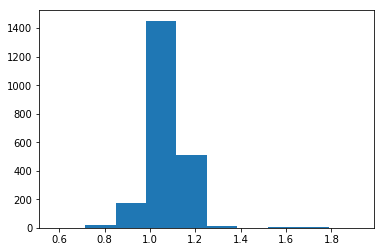

In [176]:
plt.hist(ngals/ngalsm)